<a href="https://colab.research.google.com/github/khanhvy31/Twitter-Reddit_Keywords_Analysis/blob/main/Keyword_MongoDB_Twitter_and_Reddit_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Needed Packages

In [ ]:
# import all required packages
!pip install psaw    
import nltk
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
from psaw import PushshiftAPI    #library Pushshift
import datetime as dt            #library for date management
import pandas as pd                        #library for data manipulation
import matplotlib.pyplot as plt  #library for plotting
import numpy as np
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package ieer to /root/nltk_data...
[nltk_data]   Package ieer is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-07 05:23:19.234466: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Initialize PushShiftAPI object
!pip install praw
import praw
!pip install pushshift_py
from pushshift_py import PushshiftAPI
api = PushshiftAPI()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Crawl Data from Reddit

In [ ]:
# Get Submission title data
posts = list(api.search_submissions(
        subreddit='mongodb',#Subreddit we want to audit
        after=int(dt.datetime(2001, 1, 1).timestamp()),      #Start date
        before=int(dt.datetime(2022,12,12).timestamp()),       #End date
        filter=['id', 'author', 'created_utc',
                   'domain', 'url',
                   'title', 'num_comments','selftext'] ,        #Column names we want to retrieve
        limit=6000))          ##Max number of posts
alltopic = pd.DataFrame(posts)

In [ ]:
#alltopic = alltopic.to_csv('alltopic.csv')

##Clean Data

In [ ]:
# Convert UNIX timestamp format
alltopic["created_time"] = pd.to_datetime(alltopic["created_utc"], unit='s')
alltopic['created_date'] = alltopic['created_time'].dt.date
alltopic['created_year_month'] = alltopic['created_date'].map(lambda x: x.strftime('%Y-%m'))
alltopic.head()

author  created_utc             domain      id  num_comments  \
0              __Warden   1498956107       self.mongodb  6kqiu2             5   
1                jdav89   1499082473         github.com  6kzf4v             0   
2  lookingoodindemjeans   1499116826  stackoverflow.com  6l2r4a             0   
3          sappractices   1499150064   todaycourses.com  6l5fgr             0   
4                  e-oj   1499190113         medium.com  6l8in9             0   

                                            selftext  \
0  all products collection:    \n    {\n    name ...   
1                                                      
2                                                      
3                                                      
4                                                      

                                               title  \
0              Need help deciding how to model my db   
1  GitHub user management and organization knock ...   
2              Can you use $inc on a model instance?   
3                                            MongoDB   
4  Fawn: Transactions in MongoDB across multiple ...   

                                                 url  \
0  https://www.reddit.com/r/mongodb/comments/6kqi...   
1             https://github.com/Isithelo/Fraternate   
2  https://stackoverflow.com/questions/44893663/c...   
3  http://www.todaycourses.com/learn-big-data/top...   
4  https://medium.com/@emmanuelolaojo/fawn-transa...   

                                                  d_     created  \
0  {'author': '__Warden', 'created_utc': 14989561...  1498956107   
1  {'author': 'jdav89', 'created_utc': 1499082473...  1499082473   
2  {'author': 'lookingoodindemjeans', 'created_ut...  1499116826   
3  {'author': 'sappractices', 'created_utc': 1499...  1499150064   
4  {'author': 'e-oj', 'created_utc': 1499190113, ...  1499190113   

         created_time created_date created_year_month  
0 2017-07-02 00:41:47   2017-07-02            2017-07  
1 2017-07-03 11:47:53   2017-07-03            2017-07  
2 2017-07-03 21:20:26   2017-07-03            2017-07  
3 2017-07-04 06:34:24   2017-07-04            2017-07  
4 2017-07-04 17:41:53   2017-07-04            2017-07

##Append to Body List

In [ ]:
body = alltopic[['selftext']]

##Get the comments

In [ ]:
# get submission comment data using API (store as CSV For easy loading later)
gen = api.search_comments(subreddit='mongodb')
comments = []
for c in gen:
  comments.append(c)
  
# Change list to dataframe
allcomments = pd.DataFrame([thing.d_ for thing in comments])

In [ ]:
allcomments

all_awardings  associated_award                author  \
0               []               NaN        Julianangelp21   
1               []               NaN              fefetl08   
2               []               NaN       potatokilla5000   
3               []               NaN   50KurusVerLanTirrek   
4               []               NaN         ImportantDesk   
...            ...               ...                   ...   
2450           NaN               NaN          CSEngineer13   
2451           NaN               NaN          colorcodebot   
2452           NaN               NaN                 phblj   
2453           NaN               NaN  OHotDawnThisIsMyJawn   
2454           NaN               NaN     notunlikethewaves   

     author_flair_background_color author_flair_css_class  \
0                             None                   None   
1                             None                   None   
2                             None                   None   
3                             None                   None   
4                             None                   None   
...                            ...                    ...   
2450                           NaN                   None   
2451                           NaN                   None   
2452                           NaN                   None   
2453                           NaN                   None   
2454                           NaN                   None   

     author_flair_richtext  author_flair_template_id author_flair_text  \
0                       []                       NaN              None   
1                       []                       NaN              None   
2                       []                       NaN              None   
3                       []                       NaN              None   
4                       []                       NaN              None   
...                    ...                       ...               ...   
2450                   NaN                       NaN              None   
2451                   NaN                       NaN              None   
2452                   NaN                       NaN              None   
2453                   NaN                       NaN              None   
2454                   NaN                       NaN              None   

     author_flair_text_color author_flair_type  ... collapsed  \
0                       None              text  ...       NaN   
1                       None              text  ...       NaN   
2                       None              text  ...       NaN   
3                       None              text  ...       NaN   
4                       None              text  ...       NaN   
...                      ...               ...  ...       ...   
2450                    None              None  ...       NaN   
2451                    None              None  ...       NaN   
2452                    None              None  ...       NaN   
2453                    None              None  ...       NaN   
2454                    None              None  ...       NaN   

     collapsed_reason controversiality distinguished gilded  nest_level  \
0                 NaN              NaN           NaN    NaN         NaN   
1                 NaN              NaN           NaN    NaN         NaN   
2                 NaN              NaN           NaN    NaN         NaN   
3                 NaN              NaN           NaN    NaN         NaN   
4                 NaN              NaN           NaN    NaN         NaN   
...               ...              ...           ...    ...         ...   
2450              NaN              0.0           NaN    0.0         2.0   
2451              NaN              0.0           NaN    0.0         2.0   
2452              NaN              0.0           NaN    0.0         1.0   
2453              NaN              0.0           NaN    0.0         1.0   
2454              NaN           

In [ ]:
#allcomments = allcomments.to_csv('allcomments.csv')

##Clean comment

In [ ]:
# Drop columns
allcomments = allcomments[['id', 'body', 'author', 'created_utc', 'link_id', 'locked', 'parent_id', 'score', 'score_hidden', 'subreddit', 'subreddit_id']]

# Show heads of comments_df
allcomments.head()

id                                               body  \
0  gbi35lo                    It worked, thank you so much :)   
1  gbhmr7g   I'm pretty new myself, but sure maybe I can help   
2  gbhlpe7  hey, Thanks for the reply is there a way i cou...   
3  gbfi1ru  Thank you. I was looking at official docs of m...   
4  gb5mmhj                                       Ah- thanks !   

                author  created_utc    link_id locked   parent_id  score  \
0       Julianangelp21   1604786404  t3_jpydrs  False  t1_gbi1y9p      1   
1             fefetl08   1604781095  t3_jpx3lo  False  t1_gbhlpe7      1   
2      potatokilla5000   1604780760  t3_jpx3lo  False  t1_gbhikdj      1   
3  50KurusVerLanTirrek   1604729726  t3_jplo7e  False  t1_gbfh2y7      1   
4        ImportantDesk   1604523276  t3_jna2f5  False  t1_gb50n7i      1   

  score_hidden subreddit subreddit_id  
0          NaN   mongodb     t5_2rjwd  
1          NaN   mongodb     t5_2rjwd  
2          NaN   mongodb     t5_2rjwd  
3          NaN   mongodb     t5_2rjwd  
4          NaN   mongodb     t5_2rjwd

In [ ]:
# Remove prefix for link_id and parent_id columns
allcomments['clean_link_id'] = allcomments['link_id'].apply(lambda x: x[3:])
allcomments['clean_parent_id'] = allcomments['parent_id'].apply(lambda x: x[3:])
allcomments.head()

<ipython-input-14-9bd132ad1f63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allcomments['clean_link_id'] = allcomments['link_id'].apply(lambda x: x[3:])
<ipython-input-14-9bd132ad1f63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allcomments['clean_parent_id'] = allcomments['parent_id'].apply(lambda x: x[3:])


id                                               body  \
0  gbi35lo                    It worked, thank you so much :)   
1  gbhmr7g   I'm pretty new myself, but sure maybe I can help   
2  gbhlpe7  hey, Thanks for the reply is there a way i cou...   
3  gbfi1ru  Thank you. I was looking at official docs of m...   
4  gb5mmhj                                       Ah- thanks !   

                author  created_utc    link_id locked   parent_id  score  \
0       Julianangelp21   1604786404  t3_jpydrs  False  t1_gbi1y9p      1   
1             fefetl08   1604781095  t3_jpx3lo  False  t1_gbhlpe7      1   
2      potatokilla5000   1604780760  t3_jpx3lo  False  t1_gbhikdj      1   
3  50KurusVerLanTirrek   1604729726  t3_jplo7e  False  t1_gbfh2y7      1   
4        ImportantDesk   1604523276  t3_jna2f5  False  t1_gb50n7i      1   

  score_hidden subreddit subreddit_id clean_link_id clean_parent_id  
0          NaN   mongodb     t5_2rjwd        jpydrs         gbi1y9p  
1          NaN   mongodb     t5_2rjwd        jpx3lo         gbhlpe7  
2          NaN   mongodb     t5_2rjwd        jpx3lo         gbhikdj  
3          NaN   mongodb     t5_2rjwd        jplo7e         gbfh2y7  
4          NaN   mongodb     t5_2rjwd        jna2f5         gb50n7i

In [ ]:
# Convert UNIX timestamp format
allcomments["created_time"] = pd.to_datetime(allcomments["created_utc"], unit='s')
allcomments['created_date'] = allcomments['created_time'].dt.date
allcomments['created_year_month'] = allcomments['created_date'].map(lambda x: x.strftime('%Y-%m'))
allcomments.head()

<ipython-input-15-7ecdb666ac58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allcomments["created_time"] = pd.to_datetime(allcomments["created_utc"], unit='s')
<ipython-input-15-7ecdb666ac58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allcomments['created_date'] = allcomments['created_time'].dt.date
<ipython-input-15-7ecdb666ac58>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

id                                               body  \
0  gbi35lo                    It worked, thank you so much :)   
1  gbhmr7g   I'm pretty new myself, but sure maybe I can help   
2  gbhlpe7  hey, Thanks for the reply is there a way i cou...   
3  gbfi1ru  Thank you. I was looking at official docs of m...   
4  gb5mmhj                                       Ah- thanks !   

                author  created_utc    link_id locked   parent_id  score  \
0       Julianangelp21   1604786404  t3_jpydrs  False  t1_gbi1y9p      1   
1             fefetl08   1604781095  t3_jpx3lo  False  t1_gbhlpe7      1   
2      potatokilla5000   1604780760  t3_jpx3lo  False  t1_gbhikdj      1   
3  50KurusVerLanTirrek   1604729726  t3_jplo7e  False  t1_gbfh2y7      1   
4        ImportantDesk   1604523276  t3_jna2f5  False  t1_gb50n7i      1   

  score_hidden subreddit subreddit_id clean_link_id clean_parent_id  \
0          NaN   mongodb     t5_2rjwd        jpydrs         gbi1y9p   
1          NaN   mongodb     t5_2rjwd        jpx3lo         gbhlpe7   
2          NaN   mongodb     t5_2rjwd        jpx3lo         gbhikdj   
3          NaN   mongodb     t5_2rjwd        jplo7e         gbfh2y7   
4          NaN   mongodb     t5_2rjwd        jna2f5         gb50n7i   

         created_time created_date created_year_month  
0 2020-11-07 22:00:04   2020-11-07            2020-11  
1 2020-11-07 20:31:35   2020-11-07            2020-11  
2 2020-11-07 20:26:00   2020-11-07            2020-11  
3 2020-11-07 06:15:26   2020-11-07            2020-11  
4 2020-11-04 20:54:36   2020-11-04            2020-11

##Get the title

In [ ]:
title = alltopic[['title']]

#EDA

##Groupby Month and Topics

In [ ]:
# Group by day and get count, plot to show activity over time. Discover COVID-19 had a big impact on the subreddit

# Posts/Topics creation activity
topics_create_count_df = alltopic.groupby('created_year_month').size().to_frame('count').reset_index()

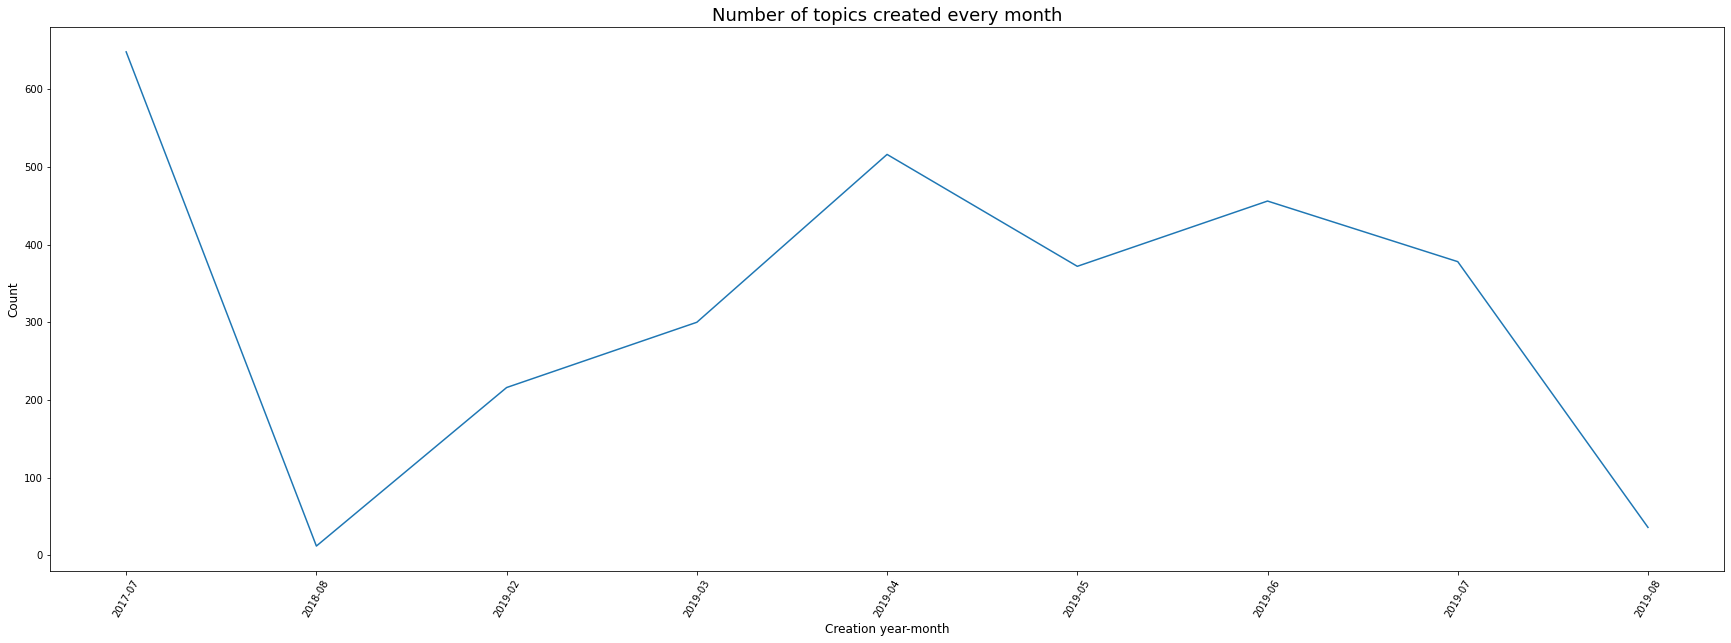

In [ ]:
#change the label of x and y 
plt.figure(figsize=(30,10))
ax = sns.lineplot(data=topics_create_count_df, x="created_year_month", y="count")
ax.set_title("Number of topics created every month", size=18)
ax.set_xlabel("Creation year-month", size=12)
ax.set_ylabel("Count", size=12)
ax.tick_params(axis='x', rotation=60)

##Wordclouds

###import needed packages

In [ ]:
#incantations for wordcloud and counters and tokenization
import nltk
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import re
from collections import Counter 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.extend(['from', 'use', 'get', 'go', 'may', 'can','say', 'https', 'http','ve'])
# TODO: tokenize and flatten
def tokenize_content(content):
  tokenized_list = nltk.word_tokenize(content)
  temp = [w.lower() for w in tokenized_list if w.isalpha()]
  res = [w for w in temp if w not in stopwords]
  return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##wordclouds for title

In [ ]:
#tokenize all submission titles
alltopiclist = [tokenize_content(row) for row in alltopic['title']]

#flatten all submission titles
flat_alltopiclist = [item for sublist in alltopiclist for item in sublist] 

#peep the output for verification
print(flat_alltopiclist)

['need', 'help', 'deciding', 'model', 'db', 'github', 'user', 'management', 'organization', 'knock', 'mongodb', 'node', 'expressjs', 'handlebars', 'inc', 'model', 'instance', 'mongodb', 'fawn', 'transactions', 'mongodb', 'across', 'multiple', 'collections', 'mongodb', 'community', 'edition', 'debian', 'jessie', 'look', 'github', 'user', 'interface', 'knock', 'using', 'mongodb', 'nodejs', 'express', 'handlebars', 'open', 'scource', 'cloudboost', 'vs', 'firebase', 'war', 'choices', 'many', 'open', 'files', 'error', 'need', 'urgent', 'help', 'document', 'validation', 'feature', 'mongodb', 'getting', 'divide', 'work', 'aggregation', 'pipeline', 'javascript', 'module', 'parsing', 'analyzing', 'modifying', 'matching', 'mongodb', 'queries', 'tips', 'pymongo', 'gridfs', 'numpy', 'arrays', 'mongodb', 'cross', 'reference', 'collections', 'mongodb', 'atlas', 'vs', 'mlab', 'three', 'free', 'months', 'atlas', 'us', 'users', 'mongodb', 'trouble', 'case', 'insensitive', 'queries', 'free', 'ebook', 'm

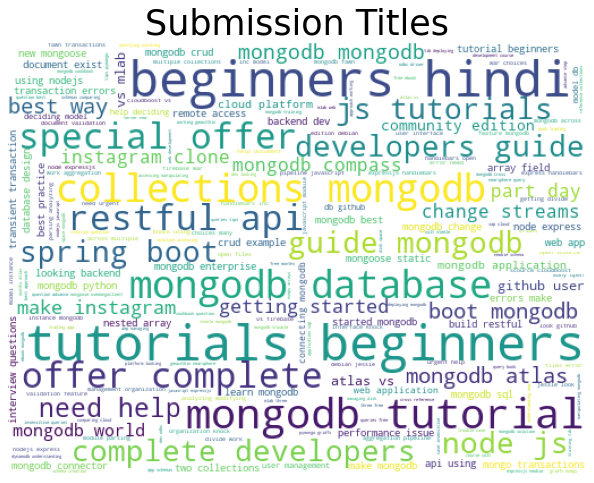

[('mongodb', 1535), ('mongo', 202), ('using', 192), ('mongoose', 161), ('data', 151), ('database', 139), ('beginners', 132), ('tutorials', 132), ('help', 124), ('array', 120), ('hindi', 108), ('document', 96), ('amp', 96), ('api', 96), ('node', 94), ('nodejs', 84), ('free', 84), ('cloud', 84), ('server', 84), ('web', 78)]


In [ ]:
#Wordcloud: Submission Titles

plt.subplots(figsize = (20,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(flat_alltopiclist))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.title('Submission Titles', fontdict=dict(size=35))

plt.show()


#Word count behind this wordcloud
cnt_title = Counter()

for word in flat_alltopiclist:
  cnt_title[word] += 1

top_title_words = cnt_title.most_common(200)
print(top_title_words[0:20])


##wordclouds for body

In [ ]:
#tokenize all submission titles
allbodylist = [tokenize_content(row) for row in alltopic['selftext']]

#flatten all submission titles
flat_allbodylist = [item for sublist in alltopiclist for item in sublist] 

#peep the output for verification
print(flat_allbodylist)

['need', 'help', 'deciding', 'model', 'db', 'github', 'user', 'management', 'organization', 'knock', 'mongodb', 'node', 'expressjs', 'handlebars', 'inc', 'model', 'instance', 'mongodb', 'fawn', 'transactions', 'mongodb', 'across', 'multiple', 'collections', 'mongodb', 'community', 'edition', 'debian', 'jessie', 'look', 'github', 'user', 'interface', 'knock', 'using', 'mongodb', 'nodejs', 'express', 'handlebars', 'open', 'scource', 'cloudboost', 'vs', 'firebase', 'war', 'choices', 'many', 'open', 'files', 'error', 'need', 'urgent', 'help', 'document', 'validation', 'feature', 'mongodb', 'getting', 'divide', 'work', 'aggregation', 'pipeline', 'javascript', 'module', 'parsing', 'analyzing', 'modifying', 'matching', 'mongodb', 'queries', 'tips', 'pymongo', 'gridfs', 'numpy', 'arrays', 'mongodb', 'cross', 'reference', 'collections', 'mongodb', 'atlas', 'vs', 'mlab', 'three', 'free', 'months', 'atlas', 'us', 'users', 'mongodb', 'trouble', 'case', 'insensitive', 'queries', 'free', 'ebook', 'm

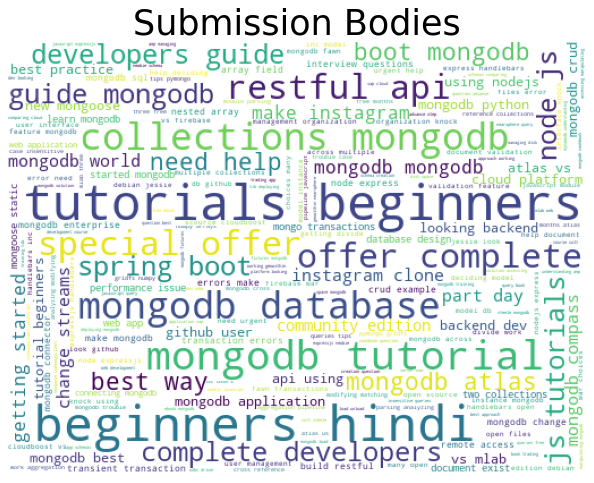

[('mongodb', 3070), ('mongo', 404), ('using', 384), ('mongoose', 322), ('data', 302), ('database', 278), ('beginners', 264), ('tutorials', 264), ('help', 248), ('array', 240), ('hindi', 216), ('document', 192), ('amp', 192), ('api', 192), ('node', 188), ('nodejs', 168), ('free', 168), ('cloud', 168), ('server', 168), ('web', 156)]


In [ ]:
##Wordcloud submission body
#Create Wordcloud and display
plt.subplots(figsize = (20,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(flat_allbodylist))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.title('Submission Bodies', fontdict=dict(size=35))

plt.show()

#Word count behind this wordcloud
for word in flat_allbodylist:
  cnt_title[word] += 1

top_body_words = cnt_title.most_common(200)
print(top_body_words[0:20])


##Wordclouds for Comments

In [ ]:
#Tokenize comments 
allcommentlist = [tokenize_content(row) for row in allcomments['body']]

#Flatten comments
flat_allcommentlist = [item for sublist in allcommentlist for item in sublist] 

#peep the output for verification
print(flat_allcommentlist)

['worked', 'thank', 'much', 'pretty', 'new', 'sure', 'maybe', 'help', 'hey', 'thanks', 'reply', 'way', 'could', 'show', 'code', 'tell', 'im', 'wrong', 'know', 'im', 'using', 'pymongo', 'already', 'im', 'using', 'examples', 'found', 'google', 'think', 'code', 'im', 'referencing', 'isnt', 'fitting', 'way', 'built', 'spider', 'thank', 'looking', 'official', 'docs', 'mongo', 'file', 'system', 'snapshots', 'resource', 'eficent', 'fle', 'system', 'level', 'face', 'performance', 'issues', 'mongodump', 'thanks', 'meant', 'using', 'insertmany', 'instead', 'plain', 'insert', 'would', 'speed', 'things', 'bit', 'problem', 'frequent', 'writing', 'db', 'inmemory', 'would', 'perfect', 'case', 'like', 'insert', 'one', 'one', 'redis', 'insert', 'many', 'redis', 'mongo', 'amazing', 'thanks', 'thank', 'got', 'burned', 'atlas', 'bandwidth', 'project', 'maintaining', 'ddos', 'ended', 'pay', 'fees', 'needed', 'capital', 'started', 'looking', 'codes', 'found', 'bunch', 'decided', 'share', 'love', 'hopes', 'o

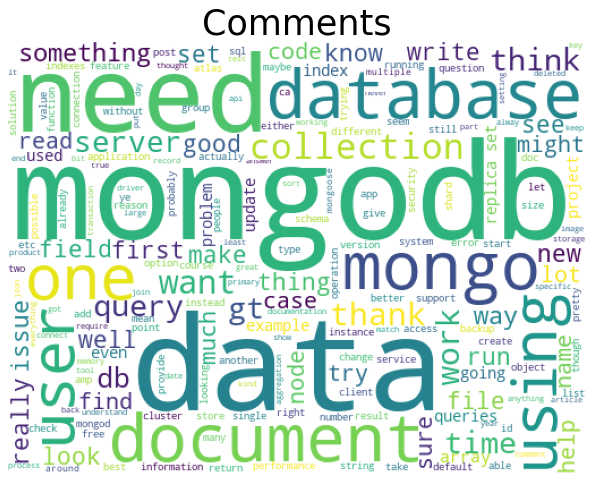

[('mongodb', 3865), ('data', 1053), ('mongo', 813), ('using', 726), ('database', 637), ('like', 568), ('would', 568), ('need', 515), ('document', 465), ('one', 449), ('set', 411), ('mongoose', 385), ('query', 384), ('help', 383), ('gt', 358), ('array', 350), ('server', 344), ('way', 330), ('collection', 327), ('want', 301)]


In [ ]:
#Wordcloud: Submission Comments
plt.subplots(figsize = (20,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(flat_allcommentlist))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.title('Comments', fontdict=dict(size=35))

plt.show()

#Word count behind this wordcloud
for word in flat_allcommentlist:
  cnt_title[word] += 1

top_comment_words = cnt_title.most_common(200)
print(top_comment_words[0:20])

#Crawl data from Twitter and import



##User have keyword Mongodb

In [ ]:
twitter = pd.read_csv('mongodb_user_tweets.csv',encoding = "ISO-8859-1")

In [ ]:
twitter_text = twitter['Text'].apply(lambda x: str(x).strip())
twitter_text

0       @quacqueline Hey Jacqueline, check out this tu...
1       In this ebook, uncover how Industry 4.0 Ñ the ...
2       __ Interested in a discussion on designing env...
3       CTO, @MarkLovesTech argues that the primary be...
4       Don't miss @_Aras_B's final blog post of a thr...
                              ...                        
3189    @JaeCoder Congrats! If you ever need help with...
3190    @danielcaetano84 Congrats! If you need any hel...
3191    @rosnovsky @bk_man @vercel @sanity_io @auth0 @...
3192    RT @MrTurnerj : My first major open source pro...
3193    @osx_unix If you want to store lists, tuples a...
Name: Text, Length: 3194, dtype: object

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.extend(['from', 'use', 'get', 'go', 'may', 'can','say', 'https', 'http','ve'])
# TODO: tokenize and flatten
def tokenize_content(content):
  tokenized_list = nltk.word_tokenize(content)
  temp = [w.lower() for w in tokenized_list if w.isalpha()]
  res = [w for w in temp if w not in stopwords]
  return res

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
twitter_text_row = [tokenize_content(row) for row in twitter_text]

#flatten all submission titles
twitter_flatten = [item for sublist in twitter_text_row for item in sublist] 

#peep the output for verification
print(twitter_flatten)

['quacqueline', 'hey', 'jacqueline', 'check', 'tutorial', 'compass', 'ebook', 'uncover', 'industry', 'ñ', 'integration', 'automation', 'technologies', 'manufacturing', 'industry', 'ñ', 'revolutionizing', 'industry', 'increased', 'connectivity', 'interested', 'discussion', 'designing', 'environmentally', 'sustainable', 'architectures', 'donõt', 'miss', 'episode', 'mongodb', 'podcast', 'cto', 'marklovestech', 'argues', 'primary', 'benefit', 'healthy', 'engineering', 'culture', 'predictability', 'learn', 'article', 'infoworld', 'thoughts', 'confluentinc', 'hashicorp', 'miss', 'final', 'blog', 'post', 'series', 'deploying', 'mongodb', 'across', 'multiple', 'clusters', 'kubernetes', 'change', 'streams', 'let', 'run', 'logic', 'data', 'changes', 'mongodb', 'collections', 'read', 'consume', 'change', 'stream', 'events', 'swift', 'application', 'new', 'mongodb', 'atlas', 'check', 'video', 'explaining', 'atlas', 'features', 'functionalities', 'ciso', 'lena', 'smart', 'talks', 'career', 'experie

##Wordcloud with keyword MongoDB

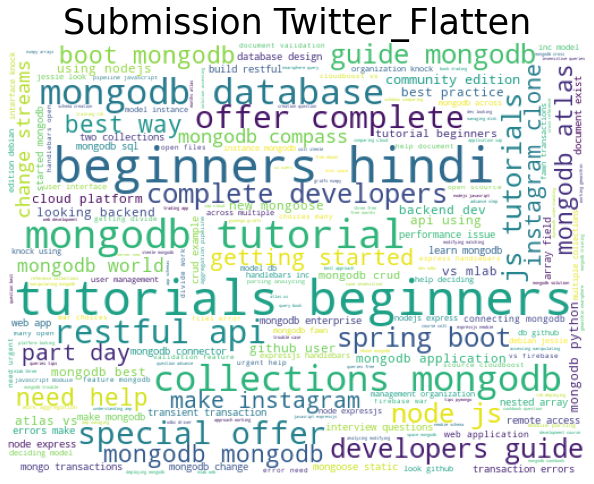

[('mongodb', 3865), ('data', 1053), ('mongo', 813), ('using', 726), ('database', 637), ('like', 568), ('would', 568), ('need', 515), ('document', 465), ('one', 449), ('set', 411), ('mongoose', 385), ('query', 384), ('help', 383), ('gt', 358), ('array', 350), ('server', 344), ('way', 330), ('collection', 327), ('want', 301), ('user', 300), ('amp', 296), ('db', 295), ('new', 291), ('make', 282), ('also', 280), ('could', 279), ('work', 269), ('tutorials', 268), ('node', 266)]


In [ ]:
#Wordcloud: Twitter_Flatten


plt.subplots(figsize = (20,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(flat_alltopiclist))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.title('Submission Twitter_Flatten', fontdict=dict(size=35))

plt.show()


#Word count behind this wordcloud
cnt_twitter = Counter()

for word in twitter_flatten:
  cnt_twitter[word] += 1

top_title_words = cnt_title.most_common(500)
print(top_title_words[0:30])


In [ ]:
hashtag_mongo = pd.read_csv('mongo.csv',encoding = "ISO-8859-1")

In [ ]:
hashtag_mongo = hashtag_mongo['Text'].apply(lambda x: str(x).strip())

In [ ]:
hashtag_mongo_row = [tokenize_content(row) for row in hashtag_mongo]

#flatten all submission titles
mongo_flatten = [item for sublist in hashtag_mongo_row for item in sublist] 

#peep the output for verification
print(mongo_flatten)

['building', 'simple', 'crud', 'app', 'node', 'express', 'mongodb', 'zellwk', 'tencent', 'cloud', 'ruby', 'sdk', 'official', 'software', 'development', 'kit', 'allows', 'ruby', 'developers', 'wri', 'rt', 'shashwatnauti', 'developer', 'roadmap', 'phase', 'html', 'semantic', 'phase', 'css', 'flex', 'grid', 'phase', 'javascript', 'promise', 'dom', 'phase', 'cli', 'phase', 'react', 'phase', 'phase', 'phase', 'internship', 'phase', 'developer', 'empezando', 'nuevo', 'proyecto', 'con', 'tendremos', 'bastantes', 'proyectos', 'de', 'para', 'los', 'videos', 'de', 'seo', 'repo', 'vite', 'reactjs', 'mongodb', 'rt', 'programmerhumor', 'rubyonrails', 'java', 'javascript', 'php', 'python', 'developer', 'coding', 'programming', 'programmer', 'nodejs', 'android', 'angular', 'lewagon', 'jquery', 'mongodb', 'django', 'devcommunity', 'linux', 'dotnet', 'elixir', 'rust', 'geek', 'technologies', 'programmerhumor', 'rubyonrails', 'java', 'javascript', 'php', 'python', 'developer', 'coding', 'programming', '

##Wordcloud with hashtag MongoDB

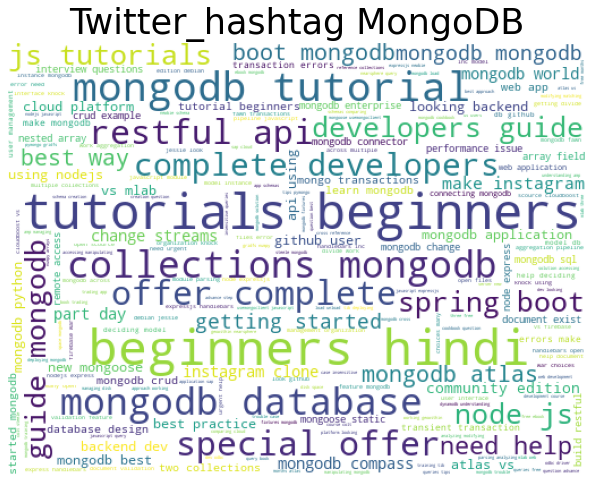

[('ð', 9937), ('project', 5328), ('miniboss', 2636), ('mongodb', 1813), ('css', 1524), ('rt', 1447), ('javascript', 1305), ('amp', 1151), ('html', 1135), ('github', 1051), ('stack', 976), ('full', 938), ('react', 936), ('nodejs', 853), ('complex', 713), ('crud', 695), ('sql', 679), ('git', 674), ('final', 670), ('pattern', 666), ('boss', 659), ('win', 658), ('chrisstaud', 649), ('framework', 518), ('api', 465), ('tailwind', 373), ('js', 326), ('python', 246), ('developer', 144), ('mentorwebdev', 144)]


In [ ]:
#Wordcloud: hashtag_mongo


plt.subplots(figsize = (20,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(flat_alltopiclist))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.title('Twitter_hashtag MongoDB', fontdict=dict(size=35))

plt.show()


#Word count behind this wordcloud
count_twitter = Counter()

for word in mongo_flatten:
  count_twitter[word] += 1

top_title_words = count_twitter.most_common(500)
print(top_title_words[0:30])

#Combine all sets to run LDA

In [ ]:
import itertools 
final = list(itertools.chain(alltopiclist,allbodylist,allcommentlist,twitter_text_row,hashtag_mongo_row))

In [ ]:
# Build the bigram and trigram models
import gensim
from gensim.utils import simple_preprocess
bigram = gensim.models.Phrases(final, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[final], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
#Form Bigrams
data_words_bigrams = make_bigrams(final)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['need', 'help', 'deciding_model', 'db']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


##Run model

In [ ]:
# Build LDA model
import numpy as np
np.random.seed = 200
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"express" + 0.039*"job" + 0.038*"python" + 0.037*"check" + '
  '0.035*"use" + 0.028*"want" + 0.024*"mongoose" + '
  '0.017*"tech_softwareengineer" + 0.013*"fun" + 0.013*"product"'),
 (1,
  '0.102*"mongodb" + 0.044*"course" + 0.037*"learn" + 0.023*"help" + '
  '0.023*"hire" + 0.020*"database" + 0.020*"work" + 0.020*"team" + '
  '0.019*"mysql" + 0.016*"look"'),
 (2,
  '0.049*"online" + 0.038*"time" + 0.030*"data" + 0.025*"scale" + '
  '0.023*"codewithvoid" + 0.022*"write" + 0.021*"detail" + 0.021*"type" + '
  '0.020*"side_project" + 0.018*"year"'),
 (3,
  '0.047*"mongodb" + 0.039*"database" + 0.035*"programming" + '
  '0.031*"development" + 0.030*"experience" + 0.026*"datum" + 0.026*"connect" '
  '+ 0.023*"server" + 0.022*"run" + 0.019*"video"'),
 (4,
  '0.265*"complex" + 0.242*"sql" + 0.073*"developer" + 0.022*"small" + '
  '0.021*"datum" + 0.019*"easy" + 0.017*"join" + 0.017*"code" + 0.012*"make" + '
  '0.012*"new"'),
 (5,
  '0.272*"nodejs" + 0.213*"ð" + 0.016*"day" + 0.0

## Visualization

In [ ]:
%matplotlib inline
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=id2word)
pyLDAvis.display(vis)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


LDA